# Klassen & Imports


In [1]:
# Zelle 1 – Imports & Grundsetup [IMP]

import math
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any, Optional
import re
import os
import ast
from pathlib import Path
import json


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap




In [2]:
# ZELLE 2 – Klassenmodell

@dataclass(frozen=True)
class Program:
    program_id: str
    license_cost_per_user: float      # €/User/Monat
    setup_cost_per_user: float        # €/User (einmalig, pro VDI)
    storage_gb_per_user: float        # GB/User/VDI

@dataclass
class Process:
    process_id: str
    programs: List[Program]           # bewusst NICHT dedupliziert

@dataclass(frozen=True)
class VDIType:
    max_hours_per_day: float          # h/Tag
    fixed_cost_per_month: float       # €/VDI/Monat

    cpu_cost_per_hour: float          # €/h
    ram_cost_per_hour: float          # €/h
    traffic_cost_per_hour: float      # €/h

    storage_os_gb: float              # GB/VDI
    storage_user_gb: float            # GB/User/VDI
    storage_cost_per_gb: float        # €/GB/Monat

@dataclass(frozen=True)
class GlobalCostParams:
    user_license_cost: float          # €/User/Monat
    user_setup_cost: float            # €/User/VDI (einmalig)

    bot_license_cost: float           # €/Bot/Monat
    bot_setup_cost: float             # €/Bot (einmalig)

    min_vdis_per_group: int = 1


@dataclass(frozen=True)
class ProcessDailyDemand:
    process_id: str
    month: int                        # 1–12
    hours_per_day: float              # h/Tag


@dataclass
class ProcessMonthCapacity:
    process_id: str
    required_users: int
    delta_users_positive: int

@dataclass
class GroupMonthCapacity:
    group_id: str
    month: int

    required_vdis: int
    delta_vdis_positive: int

    required_bots: int


@dataclass
class GroupMonthCosts:
    group_id: str
    month: int

    # Setup
    setup_user_costs: float = 0.0
    setup_program_costs: float = 0.0
    setup_bot_costs: float = 0.0

    # Laufende Kosten
    vdi_fixed_costs: float = 0.0
    user_license_costs: float = 0.0
    bot_license_costs: float = 0.0
    program_license_costs: float = 0.0

    runtime_costs: float = 0.0
    storage_costs: float = 0.0

    total_costs: float = 0.0

@dataclass
class GroupMonthKPIs:
    group_id: str
    month: int

    workload_hours_month: float
    provided_capacity_hours_month: float

    vdi_utilization: float            # Effizienz
    total_storage_gb: float

    installed_user_instances: int     # User × VDI
    installed_program_instances: int  # bewusst exponentiell

@dataclass
class ProcessGroup:
    group_id: str
    vdi_type: VDIType
    processes: List[Process]
    
@dataclass
class Konstellation:
    konstellation_id: str
    groups: List[ProcessGroup]

@dataclass
class GroupYearResult:
    group_id: str

    total_costs_year: float
    total_setup_costs_year: float

    avg_vdis: float
    avg_users: float
    avg_utilization: float

    avg_storage_gb: float

@dataclass
class KonstellationYearResult:
    konstellation_id: str
    total_costs_year: float

    group_results: Dict[str, GroupYearResult]


# Dateipfad

In [65]:
# Zelle 3 – Datei- & Pfadkonfiguration [CFG]

path_base = r"C:/Users/.../Masterarbeit/Python/python for githib/Kostenmodell github"   

# Ordner, in dem die JSON-Dateien liegen
json_folter = r"/JSON2h"
json_folder = Path(path_base + json_folter)


# Excel-Datei 
#excel_file = r"/Prozesslaufzeiten und Konfig github.xlsx" # Github
excel_file = r"/Prozesslaufzeiten und Konfig v9.xlsx"
excel_path = path_base + excel_file

# Grafik-Export
export_path = path_base + r"/Grafiken 2h je VDI"



In [4]:
# ==========================================
# Zelle 4 – Daten einlesen (Prozesse, Laufzeiten)
# ==========================================

# 📥 Excel einlesen
# df_prozesse_raw = pd.read_excel(excel_path, sheet_name="Monatslaufzeiten")
df_prozesse_raw = pd.read_excel(excel_path, sheet_name="Jahreslaufzeiten")

# 🔄 Spalten umbenennen
#df_prozesse = df_prozesse_raw.rename(columns={"Laufzeit_max": "Laufzeit"})
df_prozesse = df_prozesse_raw.rename(columns={
    "Prozess_ID": "Prozess_ID",
    "Laufzeit_max": "Laufzeit",
    "Month": "Monat"
})

# 🔢 Typ-Konvertierung
df_prozesse["Prozess_ID"] = df_prozesse["Prozess_ID"].astype(str)
df_prozesse["Laufzeit"]   = df_prozesse["Laufzeit"].astype(float)

"""
# 📆 Monate erzeugen (1–12)
MONTHS = list(range(1, 13))

df_prozesse_jahr = (
    df_prozesse
    .assign(key=1)
    .merge(
        pd.DataFrame({"Monat": MONTHS, "key": 1}),
        on="key"
    )
    .drop(columns="key")
)

# 🔢 Typ sicherstellen
df_prozesse_jahr["Monat"] = df_prozesse_jahr["Monat"].astype(int)

# 📋 Spaltenreihenfolge
df_prozesse_jahr = df_prozesse_jahr[
    ["Prozess_ID", "Monat", "Laufzeit"]
]
"""
df_prozesse_jahr = df_prozesse.copy()

# Spaltenreihenfolge
df_prozesse_jahr = df_prozesse_jahr[
    ["Prozess_ID", "Monat", "Laufzeit"]
]


# --------------------------------------------------
# Kontrolle
# --------------------------------------------------
df_process_runtime = df_prozesse_jahr.copy()

display(df_prozesse)
display(f"Anzahl Prozesse (ein Monat): {len(df_prozesse)}")
display(f"Anzahl Prozesse (12 Monate): {len(df_prozesse_jahr)}")
display(excel_path)


,Prozess_ID,Monat,Laufzeit,Laufzeit_mean,VDI-Auslastung_Max,VDI-Auslastung_Mean,VDI-Auslastung bei 1 Prozess je Pool,VDI-Auslastung bei einem Pool mit allen Prozessen
0,1000,1,155.129722,137.156944,0.646374,0.571487,8,7.756486
1,1000,2,168.407613,124.312746,0.701698,0.517970,9,8.420381
2,1000,3,170.441483,117.199562,0.710173,0.488332,9,8.522074
3,1000,4,170.800813,155.710055,0.711670,0.648792,9,8.540041
4,1000,5,170.412654,162.551841,0.710053,0.677299,9,8.520633
...,...,...,...,...,...,...,...,...
1843,1188,1,0.005833,0.005833,0.000024,0.000024,1,0.000292
1844,1188,2,0.006328,0.006328,0.000026,0.000026,1,0.000316
1845,1188,4,0.011041,0.011041,0.000046,0.000046,1,0.000552
1846,1189,1,0.008333,0.008333,0.000035,0.000035,1,0.000417


'Anzahl Prozesse (ein Monat): 1848'

'Anzahl Prozesse (12 Monate): 1848'

'C:/Users/Hippo/Documents/Uni/Masterarbeit/Python/Kostenmodell v9/Prozesslaufzeiten und Konfig v9.xlsx'

# Config einlesen

In [5]:
# =========================
# ZELLE 4 – Konfiguration
# =========================

import pandas as pd
from typing import Dict


# --------------------------------------------------
# Zeitparameter
# --------------------------------------------------

DAYS_PER_MONTH = {
    1: 31,  2: 28,  3: 31,  4: 30,
    5: 31,  6: 30,  7: 31,  8: 31,
    9: 30, 10: 31, 11: 30, 12: 31
}

MAX_HOURS_PER_DAY = 2
MONTHS_PER_YEAR = list(DAYS_PER_MONTH.keys())


# --------------------------------------------------
# Lizenzen einlesen (Excel: Sheet "Kostenkonfiguration")
# --------------------------------------------------

df_lizenzen = pd.read_excel(excel_path, sheet_name="Kostenkonfiguration")

name_col = df_lizenzen.columns[0]

for col in ["Lizenzkosten", "Speicherbedarf", "Setupkosten"]:
    if col in df_lizenzen.columns:
        df_lizenzen[col] = (
            df_lizenzen[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .astype(float)
        )

df_lizenzen = df_lizenzen.set_index(name_col)


# --------------------------------------------------
# Basis: User & Bot
# --------------------------------------------------

USER_LICENSE_COST = df_lizenzen.loc["User", "Lizenzkosten"]
USER_SETUP_COST   = df_lizenzen.loc["User", "Setupkosten"]
USER_STORAGE_GB   = df_lizenzen.loc["User", "Speicherbedarf"]

BOT_LICENSE_COST  = df_lizenzen.loc["Bot", "Lizenzkosten"]
BOT_SETUP_COST    = df_lizenzen.loc["Bot", "Setupkosten"]


GLOBAL_COST_PARAMS = GlobalCostParams(
    user_license_cost = USER_LICENSE_COST,
    user_setup_cost   = USER_SETUP_COST,

    bot_license_cost  = BOT_LICENSE_COST,
    bot_setup_cost    = BOT_SETUP_COST,

    min_vdis_per_group = 1
)


# --------------------------------------------------
# OS (pro VDI)
# --------------------------------------------------

OS_STORAGE_GB = df_lizenzen.loc["OS", "Speicherbedarf"]


# --------------------------------------------------
# Programme (alle außer User, Bot, OS)
# --------------------------------------------------

PROGRAMS: Dict[str, Program] = {}

for program_name, row in df_lizenzen.iterrows():
    if program_name in ["User", "Bot", "OS"]:
        continue

    PROGRAMS[program_name] = Program(
        program_id = program_name,
        license_cost_per_user = row["Lizenzkosten"],
        setup_cost_per_user   = row["Setupkosten"],
        storage_gb_per_user   = row["Speicherbedarf"]
    )


# --------------------------------------------------
# VDI-Konfiguration
# --------------------------------------------------

VDI_TYPES = {
    "standard": VDIType(
        max_hours_per_day       = MAX_HOURS_PER_DAY,

        fixed_cost_per_month    = 0.0,

        cpu_cost_per_hour       = 0.050,
        ram_cost_per_hour       = 0.020,
        traffic_cost_per_hour   = 0.015,

        storage_os_gb           = OS_STORAGE_GB,
        storage_user_gb         = USER_STORAGE_GB,
        storage_cost_per_gb     = 0.125
    )
}


# --------------------------------------------------
# Kontrolle / Debug
# --------------------------------------------------

print("CONFIG erfolgreich geladen.\n")

print("Globale Kostenparameter:")
print(GLOBAL_COST_PARAMS)

print("\nProgramme:")
for p in PROGRAMS.values():
    print(p)

print("\nVDI-Typen:")
for v in VDI_TYPES.values():
    print(v)

print(f"User-Instanzkosten: {USER_SETUP_COST :,.2f} €")


CONFIG erfolgreich geladen.

Globale Kostenparameter:
GlobalCostParams(user_license_cost=np.float64(60.0), user_setup_cost=np.float64(6.25), bot_license_cost=np.float64(1000.0), bot_setup_cost=np.float64(0.0), min_vdis_per_group=1)

Programme:
Program(program_id='Spezial 1', license_cost_per_user=50.0, setup_cost_per_user=0.0, storage_gb_per_user=8.0)
Program(program_id='Spezial 2', license_cost_per_user=50.0, setup_cost_per_user=0.0, storage_gb_per_user=2.0)
Program(program_id='Spezial 3', license_cost_per_user=120.0, setup_cost_per_user=0.0, storage_gb_per_user=0.2)
Program(program_id='Spezial 4', license_cost_per_user=1.0, setup_cost_per_user=0.0, storage_gb_per_user=12.0)
Program(program_id='Spezial 5', license_cost_per_user=32.0, setup_cost_per_user=0.0, storage_gb_per_user=3.0)

VDI-Typen:
VDIType(max_hours_per_day=2, fixed_cost_per_month=0.0, cpu_cost_per_hour=0.05, ram_cost_per_hour=0.02, traffic_cost_per_hour=0.015, storage_os_gb=np.float64(40.0), storage_user_gb=np.float64(5.

# Berechnungsfunktionen

In [6]:
# Zelle 5.1 - Berechnungen des Kapazitätsbedarf

def calc_required_users_per_process(
    daily_hours: float,
    max_hours_per_day: float
) -> int:
    """
    Berechnet den User-Bedarf eines Prozesses.
    User können nur einen Prozess bearbeiten.
    """
    if daily_hours <= 0:
        return 0
    return math.ceil(daily_hours / max_hours_per_day)



def calc_required_vdis(
    total_daily_hours: float,
    max_hours_per_day: float,
    min_vdis: int
) -> int:
    """
    Berechnet den VDI-Bedarf einer Prozessgruppe.
    Mindestbetrieb wird berücksichtigt.
    """
    if total_daily_hours <= 0:
        return min_vdis
    return max(min_vdis, math.ceil(total_daily_hours / max_hours_per_day))

# Zelle 5.2 - Neue Kapazitäten aufbauen

def positive_delta(current: int, previous: int) -> int:
    """
    Liefert nur positive Änderungen (Aufbau).
    Abbau ist kostenfrei.
    """
    return max(0, current - previous)

# Zelle 5.3 - SetupKosten

def calc_user_setup_cost(
    delta_users: int,
    active_vdis: int,
    user_setup_cost: float
) -> float:
    return delta_users * active_vdis * user_setup_cost

def calc_program_setup_cost(
    delta_users_per_process: Dict[str, int],
    processes: Dict[str, Process],
    active_vdis: int
) -> float:
    total = 0.0
    for pid, delta_users in delta_users_per_process.items():
        if delta_users <= 0:
            continue
        for prog in processes[pid].programs:
            total += delta_users * active_vdis * prog.setup_cost_per_user
    return total

def calc_bot_setup_cost(
    delta_vdis: int,
    bot_setup_cost: float
) -> float:
    return delta_vdis * bot_setup_cost

# Zelle 5.3 - Lizenzkosten

def calc_user_license_cost(
    total_users: int,
    user_license_cost: float
) -> float:
    return total_users * user_license_cost


def calc_bot_license_cost(
    active_vdis: int,
    bot_license_cost: float
) -> float:
    return active_vdis * bot_license_cost

def calc_program_license_cost(
    users_per_process: Dict[str, int],
    processes: Dict[str, Process]
) -> float:
    total = 0.0
    for pid, users in users_per_process.items():
        for prog in processes[pid].programs:
            total += users * prog.license_cost_per_user
    return total

# Zelle 5.4 - Laufzeitkostem


def calc_runtime_costs(
    total_monthly_hours: float,
    vdi_type: VDIType
) -> float:
    return total_monthly_hours * (
        vdi_type.cpu_cost_per_hour +
        vdi_type.ram_cost_per_hour +
        vdi_type.traffic_cost_per_hour
    )

# Zelle 5.4 - Speicher


def calc_storage_gb(
    active_vdis: int,
    users_per_process: Dict[str, int],
    processes: Dict[str, Process],
    vdi_type: VDIType
) -> float:
    # OS
    storage = active_vdis * vdi_type.storage_os_gb

    # User
    total_users = sum(users_per_process.values())
    storage += active_vdis * total_users * vdi_type.storage_user_gb

    # Programme (nicht dedupliziert, pro Prozess-User)
    for pid, users in users_per_process.items():
        for prog in processes[pid].programs:
            storage += active_vdis * users * prog.storage_gb_per_user

    return storage


def calc_storage_cost(
    storage_gb: float,
    cost_per_gb: float
) -> float:
    return storage_gb * cost_per_gb

# Zelle 5.5 - VDI-Fixkosten

def calc_vdi_fixed_cost(
    active_vdis: int,
    fixed_cost_per_month: float
) -> float:
    return active_vdis * fixed_cost_per_month

# Zelle 5.6 - VDI-Fixkosten


def calc_kpis(
    total_monthly_hours: float,
    active_vdis: int,
    max_hours_per_day: float,
    days_in_month: int,
    total_users: int
) -> Dict[str, float]:
    provided_capacity = active_vdis * max_hours_per_day * days_in_month

    utilization = (
        total_monthly_hours / provided_capacity
        if provided_capacity > 0 else 0.0
    )

    installed_user_instances = active_vdis * total_users

    return {
        "provided_capacity_hours": provided_capacity,
        "utilization": utilization,
        "installed_user_instances": installed_user_instances
    }




In [7]:
# ZELLE 7 – Monats-Simulation


def get_daily_runtimes_for_group(
    group: ProcessGroup,
    month: int,
    df_process_runtime: pd.DataFrame
) -> dict[str, float]:
    """
    Liefert tägliche Laufzeiten je Prozess einer Gruppe für einen Monat.
    """
    runtimes = {}

    for process in group.processes:
        row = df_process_runtime[
            (df_process_runtime["Prozess_ID"].astype(str) == process.process_id) &
            (df_process_runtime["Monat"] == month)
        ]

        if row.empty:
            runtimes[process.process_id] = 0.0
        else:
            runtimes[process.process_id] = float(row.iloc[0]["Laufzeit"])

    return runtimes

def simulate_process_group_year(
    group: ProcessGroup,
    df_process_runtime: pd.DataFrame,
    global_params: GlobalCostParams
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Simuliert eine Prozessgruppe über ein Jahr.
    Rückgabe:
      - Monatskosten (DataFrame)
      - Monats-KPIs (DataFrame)
    """

    prev_users_per_process = defaultdict(int)
    prev_vdis = 0

    cost_rows = []
    kpi_rows = []

    process_dict = {p.process_id: p for p in group.processes}

    for month in MONTHS_PER_YEAR:

        # --------------------------------------------------
        # 1) Laufzeiten
        # --------------------------------------------------
        daily_runtimes = get_daily_runtimes_for_group(
            group, month, df_process_runtime
        )

        total_daily_hours = sum(daily_runtimes.values())
        days = DAYS_PER_MONTH[month]
        total_monthly_hours = total_daily_hours * days

        # --------------------------------------------------
        # 2) Kapazitätsbedarf
        # --------------------------------------------------
        users_per_process = {
            pid: calc_required_users_per_process(
                hours, group.vdi_type.max_hours_per_day
            )
            for pid, hours in daily_runtimes.items()
        }

        total_users = sum(users_per_process.values())

        required_vdis = calc_required_vdis(
            total_daily_hours,
            group.vdi_type.max_hours_per_day,
            global_params.min_vdis_per_group
        )

        # --------------------------------------------------
        # 3) Deltas (nur Aufbau)
        # --------------------------------------------------
        delta_users_per_process = {
            pid: positive_delta(users_per_process[pid], prev_users_per_process[pid])
            for pid in users_per_process
        }

        delta_users_total = sum(delta_users_per_process.values())
        delta_vdis = positive_delta(required_vdis, prev_vdis)

        # --------------------------------------------------
        # 4) SetupKosten
        # --------------------------------------------------
        setup_user_cost = calc_user_setup_cost(
            delta_users_total,
            required_vdis,
            global_params.user_setup_cost
        )

        setup_program_cost = calc_program_setup_cost(
            delta_users_per_process,
            process_dict,
            required_vdis
        )

        setup_bot_cost = calc_bot_setup_cost(
            delta_vdis,
            global_params.bot_setup_cost
        )

        setup_cost_total = setup_user_cost + setup_program_cost + setup_bot_cost

        # --------------------------------------------------
        # 5) Laufende Kosten
        # --------------------------------------------------
        user_license_cost = calc_user_license_cost(
            total_users,
            global_params.user_license_cost
        )

        bot_license_cost = calc_bot_license_cost(
            required_vdis,
            global_params.bot_license_cost
        )

        program_license_cost = calc_program_license_cost(
            users_per_process,
            process_dict
        )

        runtime_cost = calc_runtime_costs(
            total_monthly_hours,
            group.vdi_type
        )

        storage_gb = calc_storage_gb(
            required_vdis,
            users_per_process,
            process_dict,
            group.vdi_type
        )

        storage_cost = calc_storage_cost(
            storage_gb,
            group.vdi_type.storage_cost_per_gb
        )

        vdi_fixed_cost = calc_vdi_fixed_cost(
            required_vdis,
            group.vdi_type.fixed_cost_per_month
        )

        total_cost = (
            setup_cost_total +
            user_license_cost +
            bot_license_cost +
            program_license_cost +
            runtime_cost +
            storage_cost +
            vdi_fixed_cost
        )

        # --------------------------------------------------
        # 6) Kosten-Output
        # --------------------------------------------------
        cost_rows.append({
            "konstellation_id": None,   # wird später gesetzt
            "group_id": group.group_id,
            "month": month,

            "total_cost": total_cost,
            "setup_cost": setup_cost_total,
            "license_cost": user_license_cost + bot_license_cost + program_license_cost,
            "runtime_cost": runtime_cost,
            "storage_cost": storage_cost,
            "vdi_fixed_cost": vdi_fixed_cost,

            "users": total_users,
            "vdis": required_vdis
        })

        # --------------------------------------------------
        # 7) KPIs
        # --------------------------------------------------
        kpis = calc_kpis(
            total_monthly_hours,
            required_vdis,
            group.vdi_type.max_hours_per_day,
            days,
            total_users
        )

        kpis.update({
            "konstellation_id": None,  # wird später gesetzt
            "group_id": group.group_id,
            "month": month,
            "storage_gb": storage_gb
        })

        kpi_rows.append(kpis)

        # --------------------------------------------------
        # 8) Zustand fortschreiben
        # --------------------------------------------------
        prev_users_per_process = users_per_process
        prev_vdis = required_vdis

    return pd.DataFrame(cost_rows), pd.DataFrame(kpi_rows)


In [8]:
def simulate_konstellation_year(
    konstellation: Konstellation,
    df_prozesse_jahr: pd.DataFrame,
    global_params: GlobalCostParams
):
    all_costs = []
    all_kpis = []

    for group in konstellation.groups:
        group_costs, group_kpis = simulate_process_group_year(
            group,
            df_prozesse_jahr,
            global_params
        )
        all_costs.extend(group_costs)
        all_kpis.extend(group_kpis)

    return pd.DataFrame(all_costs), pd.DataFrame(all_kpis)


# Konstellationen zum Rechnen laden

In [9]:
# ZELLE 6 – Konstellationen

def load_konstellationen_from_json(
    folder_path: str | Path,
    include_filename: bool = True,
) -> List[Dict[str, Any]]:
    """
    Lädt alle JSON-Konstellationen aus einem Ordner.
    """
    folder = Path(folder_path)
    konstellationen: List[Dict[str, Any]] = []

    for json_file in sorted(folder.glob("*.json")):
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if include_filename:
            data["_source_file"] = json_file.name

        konstellationen.append(data)

    return konstellationen

def load_konstellationen_from_json(
    folder_path: str | Path,
    include_filename: bool = True,
) -> List[Dict[str, Any]]:
    """
    Lädt alle JSON-Konstellationen aus einem Ordner.
    """
    folder = Path(folder_path)
    konstellationen: List[Dict[str, Any]] = []

    for json_file in sorted(folder.glob("*.json")):
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if include_filename:
            data["_source_file"] = json_file.name

        konstellationen.append(data)

    return konstellationen

def canonicalize_konstellation(konstellation: List[List[int]]) -> tuple:
    """
    Bringt eine Konstellation in eine kanonische, vergleichbare Form:
    - Prozesse innerhalb einer Gruppe sortiert
    - Gruppen untereinander sortiert
    """
    return tuple(
        sorted(
            tuple(sorted(group))
            for group in konstellation
        )
    )


def deduplicate_konstellationen(
    konstellationen: List[Dict[str, Any]]
) -> List[Dict[str, Any]]:
    """
    Entfernt identische Konstellationen.
    Identität wird ausschließlich über die Gruppierung definiert.
    """
    seen = set()
    unique: List[Dict[str, Any]] = []

    for k in konstellationen:
        key = canonicalize_konstellation(k["konstellation"])
        if key not in seen:
            seen.add(key)
            unique.append(k)
    
    return unique

# Alle Konstellationen laden
konstellationen_raw = load_konstellationen_from_json(json_folder)

loaded_konstellationen = len(konstellationen_raw)

# Duplikate entfernen
konstellationen_raw = deduplicate_konstellationen(konstellationen_raw)

print(
    f"Duplikate entfernt: "
    f"{loaded_konstellationen - len(konstellationen_raw)}, "
    f"{len(konstellationen_raw)} Konstellationen verbleiben."
)

# Kurzer Check
for k in konstellationen_raw[:3]:
    print(
        f"Konstellation '{k.get('titel', '?')}': "
        f"{len(k['konstellation'])} Gruppen "
        f"(Quelle: {k.get('_source_file', '-')})"
    )


Duplikate entfernt: 58, 68 Konstellationen verbleiben.
Konstellation 'Greedy_Poolsize1': 150 Gruppen (Quelle: konstellation_greedy_poolsize1.json)
Konstellation 'Greedy_Poolsize10': 106 Gruppen (Quelle: konstellation_greedy_poolsize10.json)
Konstellation 'Greedy_Poolsize1000': 2 Gruppen (Quelle: konstellation_greedy_poolsize1000.json)


In [10]:
def build_process_dict(
    process_program_names: Dict[str, List[str]]
) -> Dict[str, Process]:
    """
    Erzeugt Process-Objekte je Prozess-ID.
    """
    process_dict: Dict[str, Process] = {}

    for pid, program_names in process_program_names.items():
        process_dict[str(pid)] = Process(
            process_id=str(pid),
            programs=[PROGRAMS[name] for name in program_names]
        )

    return process_dict

def build_konstellation_objects(
    konstellationen_raw: List[Dict[str, Any]],
    process_dict: Dict[str, Process],
    vdi_type: VDIType
) -> List[Konstellation]:
    """
    Wandelt rohe Konstellationen in Modellobjekte um.
    """
    konstellationen: List[Konstellation] = []

    for idx, k in enumerate(konstellationen_raw):
        groups: List[ProcessGroup] = []

        for g_idx, group_pids in enumerate(k["konstellation"]):
            processes = [
                process_dict[str(pid)]
                for pid in group_pids
                if str(pid) in process_dict
            ]

            groups.append(
                ProcessGroup(
                    group_id=f"{k.get('titel', 'K')}_G{g_idx+1}",
                    vdi_type=vdi_type,
                    processes=processes
                )
            )

        konstellationen.append(
            Konstellation(
                konstellation_id=k.get("titel", f"K{idx+1}"),
                groups=groups
            )
        )

    return konstellationen

# =========================
# ZELLE 6.start
# =========================


# Programme je Prozess aus df_prozesse_jahr ableiten
PROGRAM_COLUMNS = [
    col for col in df_prozesse_jahr.columns
    if col not in ["Prozess_ID", "Monat", "Laufzeit"]
]

process_program_names = (
    df_prozesse_jahr
    .groupby("Prozess_ID")[PROGRAM_COLUMNS]
    .max()
    .fillna(0)
    .astype(int)
)

PROCESS_PROGRAM_NAMES = {
    str(pid): [
        prog for prog, flag in row.items() if flag == 1
    ]
    for pid, row in process_program_names.iterrows()
}

# Process-Objekte bauen
process_dict = build_process_dict(PROCESS_PROGRAM_NAMES)

#  HIER entsteht `konstellationen`
konstellationen = build_konstellation_objects(
    konstellationen_raw=konstellationen_raw,
    process_dict=process_dict,
    vdi_type=VDI_TYPES["standard"]
)

print(f"{len(konstellationen)} Konstellationen als Modellobjekte gebaut.")


68 Konstellationen als Modellobjekte gebaut.


# Rechnung starten

In [11]:
# ZELLE 7 – Simulation

from collections import defaultdict


def simulate_konstellation_year(
    konstellation: Konstellation,
    df_process_runtime: pd.DataFrame,
    global_params: GlobalCostParams
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Simuliert alle Gruppen einer Konstellation.
    """

    all_costs = []
    all_kpis = []

    for group in konstellation.groups:
        group_costs, group_kpis = simulate_process_group_year(
            group,
            df_process_runtime,
            global_params
        )

        group_costs["konstellation_id"] = konstellation.konstellation_id
        group_kpis["konstellation_id"] = konstellation.konstellation_id

        all_costs.append(group_costs)
        all_kpis.append(group_kpis)

    return (
        pd.concat(all_costs, ignore_index=True),
        pd.concat(all_kpis, ignore_index=True)
    )


def simulate_all_konstellationen(
    konstellationen: list[Konstellation],
    df_process_runtime: pd.DataFrame,
    global_params: GlobalCostParams
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Simuliert alle Konstellationen.
    """

    cost_frames = []
    kpi_frames = []

    for kon in konstellationen:
        costs, kpis = simulate_konstellation_year(
            kon,
            df_process_runtime,
            global_params
        )
        cost_frames.append(costs)
        kpi_frames.append(kpis)

    return (
        pd.concat(cost_frames, ignore_index=True),
        pd.concat(kpi_frames, ignore_index=True)
    )

# =========================
# ZELLE 7. start
# =========================
df_process_runtime = df_prozesse_jahr


df_costs, df_kpis = simulate_all_konstellationen(
    konstellationen=konstellationen,
    df_process_runtime=df_process_runtime,
    global_params=GLOBAL_COST_PARAMS
)

print("Simulation abgeschlossen.")
print(f"Kosten-Zeilen: {len(df_costs)}")
print(f"KPI-Zeilen:    {len(df_kpis)}")



Simulation abgeschlossen.
Kosten-Zeilen: 77436
KPI-Zeilen:    77436


In [12]:
display(df_costs.tail(3))
display(df_kpis.tail(3))

,konstellation_id,group_id,month,total_cost,setup_cost,license_cost,runtime_cost,storage_cost,vdi_fixed_cost,users,vdis
77433,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,10,4287.916717,0.0,4240.0,17.916717,30.0,0.0,4,4
77434,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,11,4287.710993,0.0,4240.0,17.710993,30.0,0.0,4,4
77435,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,12,2143.016190,0.0,2120.0,10.516190,12.5,0.0,2,2


,provided_capacity_hours,utilization,installed_user_instances,konstellation_id,group_id,month,storage_gb
77433,248,0.849939,16,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,10,240.0
77434,240,0.868186,16,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,11,240.0
77435,124,0.997741,4,ScoreGreedy_b1.1_Poolsize8,ScoreGreedy_b1.1_Poolsize8_G103,12,100.0


In [13]:

# ZELLE 8.1 – Auswertung & Aggregation (2-stufig)

# --------------------------------------------------
# Sicherheitschecks
# --------------------------------------------------

required_cost_cols = {
    "konstellation_id", "group_id", "month",
    "total_cost", "setup_cost", "license_cost",
    "runtime_cost", "storage_cost", "vdi_fixed_cost",
    "users", "vdis"
}

required_kpi_cols = {
    "konstellation_id", "group_id", "month",
    "provided_capacity_hours", "utilization",
    "installed_user_instances", "storage_gb"
}

assert required_cost_cols.issubset(df_costs.columns)
assert required_kpi_cols.issubset(df_kpis.columns)



# ---- Kosten & Kapazitäten (monatsweise, gruppenübergreifend) ----
costs_monthly = (
    df_costs
    .groupby(["konstellation_id", "month"], as_index=False)
    .agg({
        "total_cost": "sum",
        "setup_cost": "sum",
        "license_cost": "sum",
        "runtime_cost": "sum",
        "storage_cost": "sum",
        "vdi_fixed_cost": "sum",
        "users": "sum",
        "vdis": "sum",
    })
)

# ---- KPIs (monatsweise, gruppenübergreifend) ----
kpis_monthly = (
    df_kpis
    .groupby(["konstellation_id", "month"], as_index=False)
    .agg({
        "provided_capacity_hours": "sum",
        "installed_user_instances": "sum",
        "storage_gb": "sum",
    })
)

# Laufzeit (effektiv genutzt)
kpis_monthly["process_runtime_hours"] = (
    df_kpis
    .assign(
        process_runtime_hours=lambda x:
            x["utilization"] * x["provided_capacity_hours"]
    )
    .groupby(["konstellation_id", "month"])["process_runtime_hours"]
    .sum()
    .values
)



In [14]:

# ==================================================
# ZELLE 8.2 Aggregation je Konstellation (Jahr)
# ==================================================

results = []

pools_per_kon = (
    df_costs[["konstellation_id", "group_id"]]
    .drop_duplicates()
    .groupby("konstellation_id")
    .size()
)

ref_kon_id = pools_per_kon.idxmax()
max_pools = pools_per_kon.max()

for kon_id in costs_monthly["konstellation_id"].unique():

    c_m = costs_monthly[costs_monthly["konstellation_id"] == kon_id]
    k_m = kpis_monthly[kpis_monthly["konstellation_id"] == kon_id]

    # -------------------------------
    # Kosten (Jahr = Summe über Monate)
    # -------------------------------
    total_costs = c_m["total_cost"].sum()
    setup_costs_total = c_m["setup_cost"].sum()
    license_costs_total = c_m["license_cost"].sum()
    resource_costs_total = c_m["runtime_cost"].sum()
    storage_costs_total = c_m["storage_cost"].sum()
    vdi_fixed_costs_total = c_m["vdi_fixed_cost"].sum()

    # -------------------------------
    # Laufzeit & Effizienz (Jahr)
    # -------------------------------
    total_process_runtime_hours = k_m["process_runtime_hours"].sum()
    total_provided_capacity_hours = k_m["provided_capacity_hours"].sum()

    runtime_efficiency = (
        total_process_runtime_hours / total_provided_capacity_hours
        if total_provided_capacity_hours > 0 else 0.0
    )

    # -------------------------------
    # Strukturkennzahlen (Ø über Monate)
    # -------------------------------
    avg_vdis = c_m["vdis"].mean()
    avg_users = c_m["users"].mean()
    avg_user_instances = k_m["installed_user_instances"].mean()

    avg_users_per_vdi = (
        avg_users / avg_vdis
        if avg_vdis > 0 else 0.0
    )

    # -------------------------------
    # Speicher (Ø / Peak über Monate)
    # -------------------------------
    avg_storage_gb = k_m["storage_gb"].mean()
    max_storage_gb = k_m["storage_gb"].max()

    # -------------------------------
    # Zusatzkennzahlen
    # -------------------------------
    setup_share = setup_costs_total / total_costs if total_costs > 0 else 0.0
    license_share = license_costs_total / total_costs if total_costs > 0 else 0.0
    resource_share = resource_costs_total / total_costs if total_costs > 0 else 0.0
    storage_share = storage_costs_total / total_costs if total_costs > 0 else 0.0

    cost_per_runtime_hour = (
        total_costs / total_process_runtime_hours
        if total_process_runtime_hours > 0 else np.nan
    )

    anzahl_pools = pools_per_kon[kon_id]

    prozesse_je_pool = max_pools / anzahl_pools


    # -------------------------------
    # Ergebnis
    # -------------------------------
    results.append({
        "Konstellation": kon_id,
        "Anzahl Pools": df_costs[
            df_costs["konstellation_id"] == kon_id
        ]["group_id"].nunique(),

        # Kosten (TEUR)
        "Gesamtkosten Jahr": total_costs / 1000,
        "Setupkosten": setup_costs_total / 1000,
        "Lizenzkosten": license_costs_total / 1000,
        "Ressourcenkosten": resource_costs_total / 1000,
        "Speicherkosten": storage_costs_total / 1000,
        "VDI-Fixkosten": vdi_fixed_costs_total / 1000,

        # Laufzeit
        "Gesamt Prozesslaufzeit": total_process_runtime_hours / 8760,
        "Gesamt VDI-Kapazität": total_provided_capacity_hours / 8760,
        "Laufzeit-Effizienz": runtime_efficiency,

        # Struktur
        "Ø VDIs": avg_vdis,
        "Ø User": avg_users,
        "Ø User-Instanzen": avg_user_instances,
        "User-Instanzen/VDI": avg_user_instances/avg_vdis,
        "Ø User / VDI": avg_users_per_vdi,
        "Prozesse je Pool": max_pools / pools_per_kon[kon_id],

        # Speicher
        "Ø Speicher (TB)": avg_storage_gb / 1000,
        "Speicher (TB)": max_storage_gb / 1000,

        # Anteile & Effizienz
        "Setup-Anteil (%)": setup_share,
        "Lizenz-Anteil (%)": license_share,
        "Ressourcen-Anteil (%)": resource_share,
        "Speicher-Anteil (%)": storage_share,
        "Kosten pro Prozessstunde": cost_per_runtime_hour,
    })


df_results = (
    pd.DataFrame(results)
    .sort_values("Gesamtkosten Jahr")
    .reset_index(drop=True)
)
#print(df_results)

# Ergebnisse
 

In [15]:
def format_results_df(df: pd.DataFrame, format_map: dict) -> pd.DataFrame:
    """
    Gibt ein formatiertes DataFrame für Anzeige zurück.
    Rohdaten bleiben unverändert.
    """
    df_fmt = df.copy()

    for col, fmt in format_map.items():
        if col in df_fmt.columns:
            df_fmt[col] = df_fmt[col].apply(
                lambda x: fmt.format(x) if pd.notna(x) else ""
            )

    return df_fmt

DISPLAY_COLUMNS = [
    "Konstellation",
    "Anzahl Pools",

    # Kosten (bewusst ausgewählt)
    "Gesamtkosten Jahr",
    "Setupkosten",
    "Lizenzkosten",
    "Ressourcenkosten",
    "Speicherkosten",
#    "VDI-Fixkosten",

    # Effizienz
    "Laufzeit-Effizienz",

    # Struktur
    "Ø VDIs",
#    "Ø User / VDI",
    "Ø User-Instanzen",
    "User-Instanzen/VDI",
    "Prozesse je Pool",


    # Speicher
    "Speicher (TB)",
#    "Kosten pro Prozessstunde",

    # Zusatz
#    "Setup-Anteil (%)",
#    "Lizenz-Anteil (%)",
#    "Ressourcen-Anteil (%)",
#    "Speicher-Anteil (%)",
    "Kosten pro Prozessstunde"
]



FORMAT_MAP = {
    # -------------------
    # Kosten
    # -------------------
    "Gesamtkosten Jahr": "{:,.0f} TEU",
    "Setupkosten": "{:,.0f} TEU",
    "Lizenzkosten": "{:,.0f} TEU",
    "Ressourcenkosten": "{:,.0f} TEU",
    "Speicherkosten": "{:,.0f} TEU",
    "VDI-Fixkosten": "{:,.0f} TEU",

    # -------------------
    # Laufzeit & Kapazität
    # -------------------
    "Gesamt Prozesslaufzeit": "{:,.0f} Jahre",
    "Gesamt VDI-Kapazität": "{:,.0f} Jahre",
    "Laufzeit-Effizienz": "{:.2%}",   # ACHTUNG: Wert 0–1!

    # -------------------
    # Struktur
    # -------------------
    "Ø VDIs": "{:,.1f}",
    "Ø User": "{:,.1f}",
    "Ø User-Instanzen": "{:,.0f}",
    "Ø User / VDI": "{:,.2f}",
    "User-Instanzen/VDI": "{:,.2f}",
    "Ø Prozesse / VDI": "{:,.2f}",
    "Prozesse je Pool": "{:,.1f}",

    # -------------------
    # Speicher
    # -------------------
    "Ø Speicher (TB)": "{:,.2f}",
    "Speicher (TB)": "{:,.2f}",

    # -------------------
    # Zusatz (optional)
    # -------------------
    "Setup-Anteil (%)": "{:.1%}",
    "Lizenz-Anteil (%)": "{:.1%}",
    "Ressourcen-Anteil (%)": "{:.1%}",
    "Speicher-Anteil (%)": "{:.1%}",
    "Kosten pro Prozessstunde": "{:,.2f} €",
}


df_results_formatted = format_results_df(df_results, FORMAT_MAP)

df_display = pd.concat([
    df_results_formatted.head(10),
    df_results_formatted.tail(3)
])

display(df_display[DISPLAY_COLUMNS])

# Index der Extremwerte bestimmen
idx_min_groups = df_results["Anzahl Pools"].idxmin()
idx_max_groups = df_results["Anzahl Pools"].idxmax()

# Gemeinsame Tabelle bauen
df_group_extremes = df_results_formatted.loc[
    [idx_min_groups, idx_max_groups]
].reset_index(drop=True)

df_group_extremes.loc[0, "Konstellation"] = "Ein großer Pool"
df_group_extremes.loc[1, "Konstellation"] = "Isolierte Prozesse"

display(df_group_extremes[DISPLAY_COLUMNS])


,Konstellation,Anzahl Pools,Gesamtkosten Jahr,Setupkosten,Lizenzkosten,Ressourcenkosten,Speicherkosten,Laufzeit-Effizienz,Ø VDIs,Ø User-Instanzen,User-Instanzen/VDI,Prozesse je Pool,Speicher (TB),Kosten pro Prozessstunde
0,ScoreGreedy_b1.1_Poolsize14,77,"21,883 TEU",698 TEU,"20,576 TEU",98 TEU,511 TEU,97.73%,"1,614.8","55,156",34.16,2.5,410.06,19.01 €
1,PreSeedingBestFit_Poolsize14,77,"21,885 TEU",698 TEU,"20,578 TEU",98 TEU,511 TEU,97.72%,"1,615.0","55,201",34.18,2.5,409.50,19.01 €
2,PreSeedingBestFit_Poolsize18,67,"21,888 TEU",730 TEU,"20,533 TEU",98 TEU,527 TEU,97.94%,"1,611.2","57,406",35.63,2.8,422.15,19.01 €
3,ScoreGreedy_b1.1_Poolsize18,67,"21,891 TEU",729 TEU,"20,537 TEU",98 TEU,527 TEU,97.92%,"1,611.6","57,410",35.62,2.8,422.23,19.02 €
4,ScoreGreedy_b1.1_Poolsize16,71,"21,897 TEU",714 TEU,"20,566 TEU",98 TEU,519 TEU,97.78%,"1,614.0","56,326",34.90,2.7,415.70,19.02 €
5,PreSeedingBestFit_Poolsize16,71,"21,900 TEU",713 TEU,"20,570 TEU",98 TEU,519 TEU,97.75%,"1,614.3","56,302",34.88,2.7,416.00,19.02 €
6,Greedy_Poolsize22,69,"21,902 TEU",720 TEU,"20,559 TEU",98 TEU,525 TEU,97.81%,"1,613.4","57,082",35.38,2.7,418.64,19.03 €
7,Greedy_Poolsize24,66,"21,907 TEU",733 TEU,"20,546 TEU",98 TEU,530 TEU,97.88%,"1,612.3","57,821",35.86,2.9,423.36,19.03 €
8,Greedy_Poolsize20,73,"21,915 TEU",709 TEU,"20,589 TEU",98 TEU,519 TEU,97.66%,"1,615.9","56,326",34.86,2.6,414.54,19.04 €
9,Greedy_Poolsize18,76,"21,920 TEU",703 TEU,"20,606 TEU",98 TEU,513 TEU,97.57%,"1,617.3","55,500",34.32,2.5,410.69,19.04 €


,Konstellation,Anzahl Pools,Gesamtkosten Jahr,Setupkosten,Lizenzkosten,Ressourcenkosten,Speicherkosten,Laufzeit-Effizienz,Ø VDIs,Ø User-Instanzen,User-Instanzen/VDI,Prozesse je Pool,Speicher (TB),Kosten pro Prozessstunde
0,Ein großer Pool,2,"47,790 TEU","17,388 TEU","20,148 TEU",98 TEU,"10,156 TEU",99.93%,"1,579.2","1,341,441",849.46,94.5,"8,389.75",41.51 €
1,Isolierte Prozesse,189,"22,816 TEU",642 TEU,"21,587 TEU",98 TEU,489 TEU,92.87%,"1,699.1","51,601",30.37,1.0,391.25,19.82 €


# Grafiken, Auswertungen und Exports

In [43]:
modi=f" - {MAX_HOURS_PER_DAY}h täglicher VDI-Laufzeit"

In [84]:
# Titel definieren (analog zu den Grafiken)
title_excel = "Kostenstruktur_alle_Konstellationen"

# Dateiname erzeugen
excel_filename = (
    re.sub(r"[^\w\s-]", "", title_excel)
    .strip()
    .replace(" ", "_") + ".xlsx"
)

# Pfad (gleicher Exportpfad wie Grafiken)
excel_filepath = os.path.join(export_path, excel_filename)

# Excel-Export
df_results_formatted.to_excel(excel_filepath, index=False)

print(f"Excel-Datei gespeichert unter:\n{excel_filepath}")


Excel-Datei gespeichert unter:
C:/Users/.../Masterarbeit/Python/Kostenmodell v9/Grafiken 2h je VDI\Kostenstruktur_alle_Konstellationen.xlsx


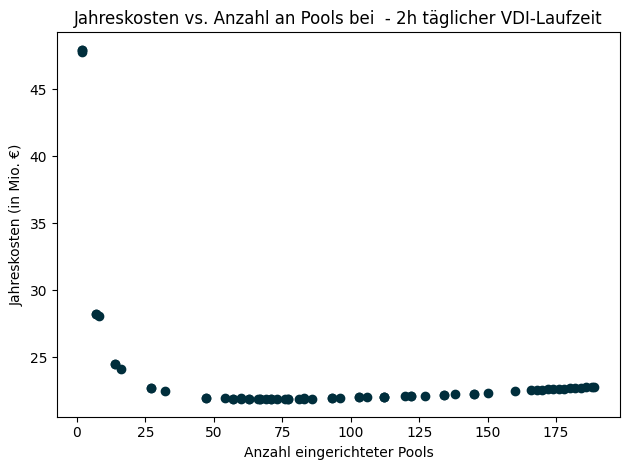

In [85]:

# Zelle 10 – Visualisierung der Kosten- und Kapazitätsstruktur [VIS]


# Titel definieren
title = f"Jahreskosten vs. Anzahl an Pools bei {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Anzahl Pools"],
    df_results["Gesamtkosten Jahr"] / 1000,
    color="#002E3C")
plt.xlabel("Anzahl eingerichteter Pools")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()

In [86]:
print(df_results[["Ø User-Instanzen", "Lizenzkosten"]].corr())
print(df_results[["Ø VDIs", "Lizenzkosten"]].corr())
print(df_results[["Gesamt Prozesslaufzeit", "Lizenzkosten"]].corr())


                  Ø User-Instanzen  Lizenzkosten
Ø User-Instanzen          1.000000     -0.433873
Lizenzkosten             -0.433873      1.000000
              Ø VDIs  Lizenzkosten
Ø VDIs           1.0           1.0
Lizenzkosten     1.0           1.0
                        Gesamt Prozesslaufzeit  Lizenzkosten
Gesamt Prozesslaufzeit                     NaN           NaN
Lizenzkosten                               NaN           1.0


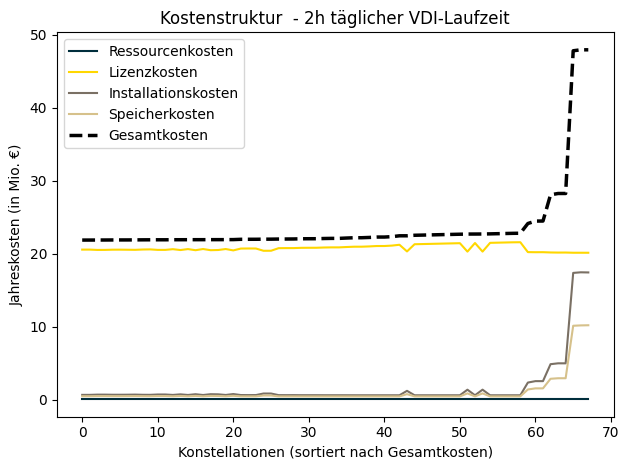

In [87]:
# Titel definieren
title = f"Kostenstruktur {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + "_line.png"
filepath = os.path.join(export_path, filename)

# X-Achse
x = range(len(df_results))

# Kosten in Mio. €
ressourcen = df_results["Ressourcenkosten"] / 1000
lizenz = df_results["Lizenzkosten"] / 1000
setup = df_results["Setupkosten"] / 1000
speicher = df_results["Speicherkosten"] / 1000

# Gesamtkosten berechnen
gesamt = ressourcen + lizenz + setup + speicher

plt.figure()

# Einzelkosten als Linien
plt.plot(x, ressourcen, label="Ressourcenkosten", color="#002E3C")
plt.plot(x, lizenz, label="Lizenzkosten", color="#FFD700")
plt.plot(x, setup, label="Installationskosten", color="#7A7064")
plt.plot(x, speicher, label="Speicherkosten", color="#D6C18B")

# Gesamtkosten hervorheben
plt.plot(
    x,
    gesamt,
    label="Gesamtkosten",
    color="black",
    linewidth=2.5,
    linestyle="--"
)

plt.xlabel("Konstellationen (sortiert nach Gesamtkosten)")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


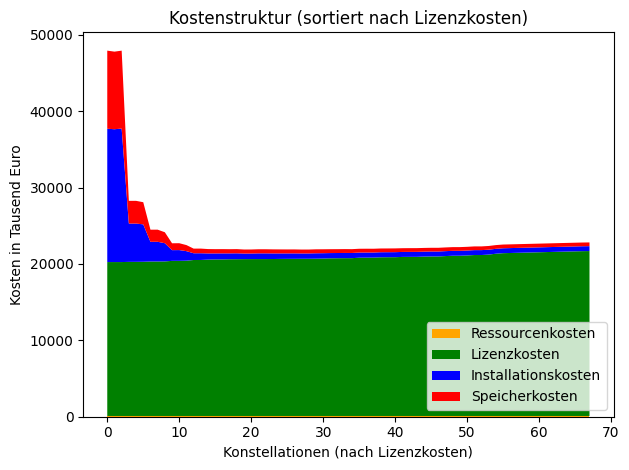

In [88]:
# -----------------------------
# Nach Lizenzkosten sortieren
# -----------------------------
df_sorted_by_license = df_results.sort_values(
    by="Lizenzkosten", ascending=True
).reset_index(drop=True)

# Titel definieren
title_license = "Kostenstruktur (sortiert nach Lizenzkosten)"

# Speicherpfad
filename_license = (re.sub(r"[^\w\s-]", "", title_license).strip().replace(" ", "_") + ".png")
filepath_license = os.path.join(export_path, filename_license)

# Plot
plt.figure()
plt.stackplot(
    range(len(df_sorted_by_license)),
    df_sorted_by_license["Ressourcenkosten"],
    df_sorted_by_license["Lizenzkosten"],
    df_sorted_by_license["Setupkosten"],
    df_sorted_by_license["Speicherkosten"],
    labels=[
        "Ressourcenkosten",
        "Lizenzkosten",
        "Installationskosten",
        "Speicherkosten",
    ],
    colors=["orange", "green", "blue", "red"],
)

plt.xlabel("Konstellationen (nach Lizenzkosten)")
plt.ylabel("Kosten in Tausend Euro")
plt.title(title_license)

plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(filepath_license, dpi=300)
plt.show()


In [89]:
# =========================
# ZELLE 11 – Analyse & Visualisierung
# =========================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

assert "df_results" in globals(), (
    "df_results existiert nicht. "
    "Bitte zuerst ZELLE 8 (Auswertung & Aggregation) ausführen."
)


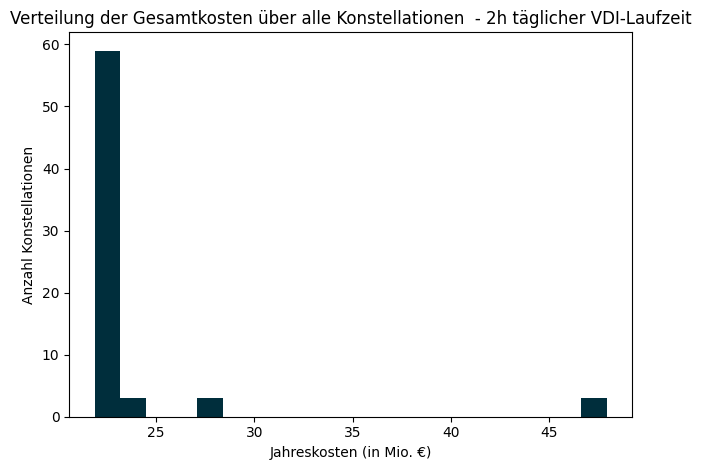

In [90]:
# Titel definieren
title = f"Verteilung der Gesamtkosten über alle Konstellationen {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.hist(df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C", bins=20)
plt.xlabel("Jahreskosten (in Mio. €)")
plt.ylabel("Anzahl Konstellationen")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


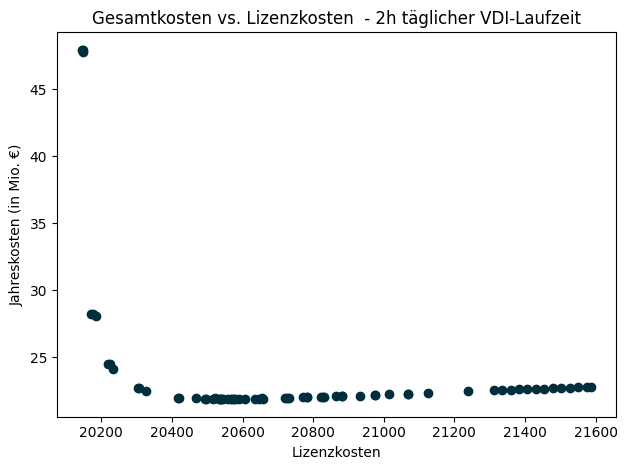

In [91]:
# Titel definieren
title = f"Gesamtkosten vs. Lizenzkosten {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Lizenzkosten"],
    df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C"
)
plt.xlabel("Lizenzkosten")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


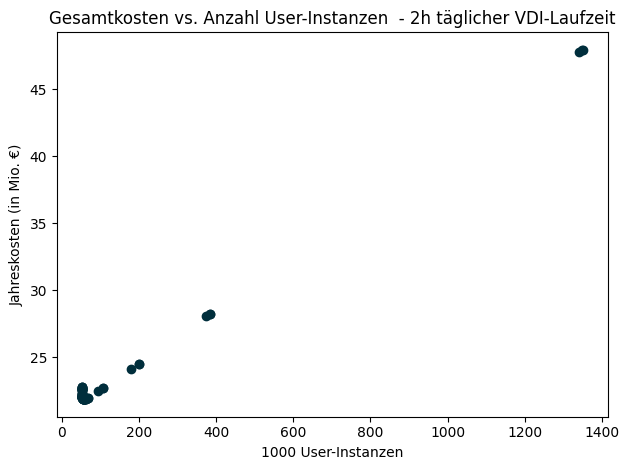

In [92]:
# Titel definieren
title = f"Gesamtkosten vs. Anzahl User-Instanzen {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Ø User-Instanzen"]/1000,
    df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C"
)
plt.xlabel("1000 User-Instanzen")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


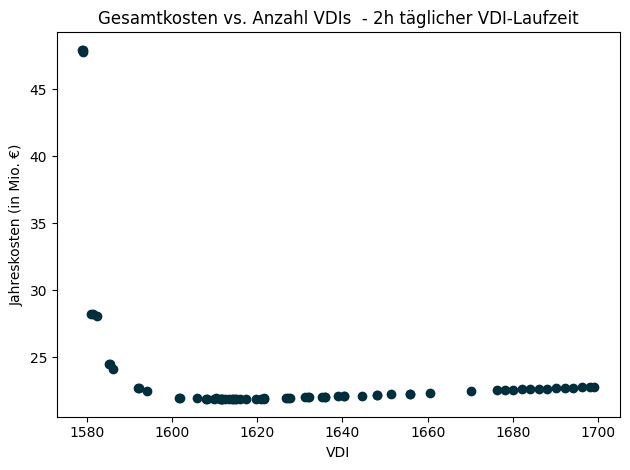

In [93]:
# Titel definieren
title = f"Gesamtkosten vs. Anzahl VDIs {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Ø VDIs"],
    df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C"
)
plt.xlabel("VDI")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


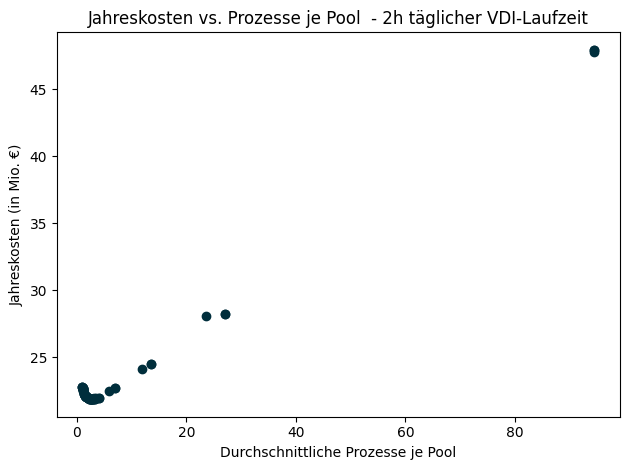

In [94]:
# Titel definieren
title = f"Jahreskosten vs. Prozesse je Pool {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Prozesse je Pool"],
    df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C"
)
plt.xlabel("Durchschnittliche Prozesse je Pool")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


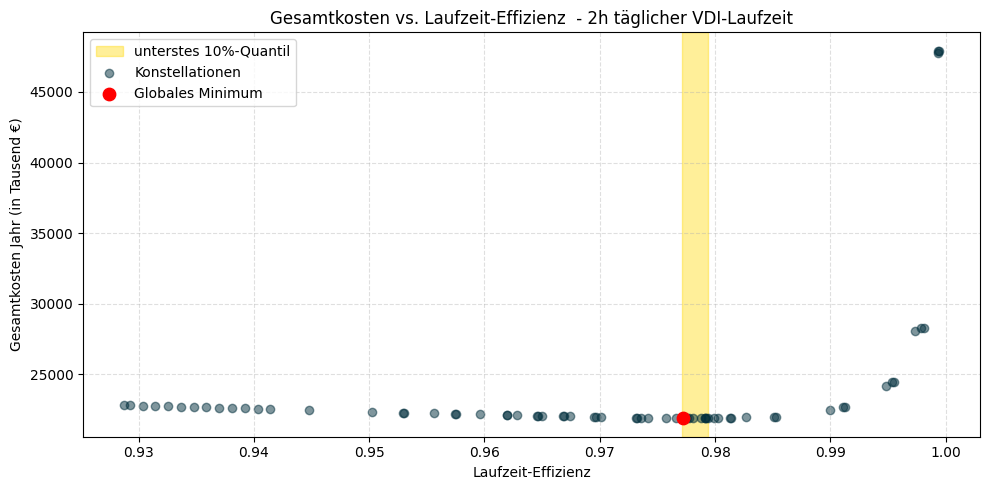

Globales Minimum der Kurve:
  Laufzeit-Effizienz : 0.977
  Gesamtkosten Jahr  : 21882.590

Kostenminimum – unterstes 10%-Quantil:
  x-Bereich: [0.977, 0.979]
  Kosten-Schwelle (10%-Quantil): 21905.525


In [95]:
# ---------- Berechnungen ----------
quantile = 0.10
# 10%-Quantil der y-Achse (Gesamtkosten)
y_quantile_10 = df_results["Gesamtkosten Jahr"].quantile(quantile)

# Punkte in den besten 10%
best_10pct = df_results[
    df_results["Gesamtkosten Jahr"] <= y_quantile_10
]

# x-Bereich der besten 10%
x_min_best = best_10pct["Laufzeit-Effizienz"].min()
x_max_best = best_10pct["Laufzeit-Effizienz"].max()

# Globales Minimum der Kurve
idx_min = df_results["Gesamtkosten Jahr"].idxmin()
x_min = df_results.loc[idx_min, "Laufzeit-Effizienz"]
y_min = df_results.loc[idx_min, "Gesamtkosten Jahr"]

# ---------- Export ----------

# Titel definieren
title = f"Gesamtkosten vs. Laufzeit-Effizienz {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

# ---------- Plot ----------


plt.figure(figsize=(10, 5))

# Bereich der besten 10% an der x-Achse markieren
plt.axvspan(
    x_min_best,
    x_max_best,
    color="#FFD700",
    alpha=0.4,
    label=f"unterstes {quantile*100:.0f}%-Quantil"
)


# Scatterplot
plt.scatter(
    df_results["Laufzeit-Effizienz"],
    df_results["Gesamtkosten Jahr"],
    alpha=0.5,
    label="Konstellationen",
    color="#002E3C"
)


# Minimum hervorheben
plt.scatter(
    x_min,
    y_min,
    color="red",
    s=80,
    zorder=5,
    label="Globales Minimum"
)

plt.xlabel("Laufzeit-Effizienz")
plt.ylabel("Gesamtkosten Jahr (in Tausend €)")
plt.title(title)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()

# ---------- Formatierung ----------
DECIMALS = 3
fmt = f"{{:.{DECIMALS}f}}"

# ---------- Print-Ausgabe ----------

print("Globales Minimum der Kurve:")
print(f"  Laufzeit-Effizienz : {fmt.format(x_min)}")
print(f"  Gesamtkosten Jahr  : {fmt.format(y_min)}")

print(f"\nKostenminimum – unterstes {quantile*100:.0f}%-Quantil:")
print(f"  x-Bereich: [{fmt.format(x_min_best)}, {fmt.format(x_max_best)}]")
print(f"  Kosten-Schwelle (10%-Quantil): {fmt.format(y_quantile_10)}")

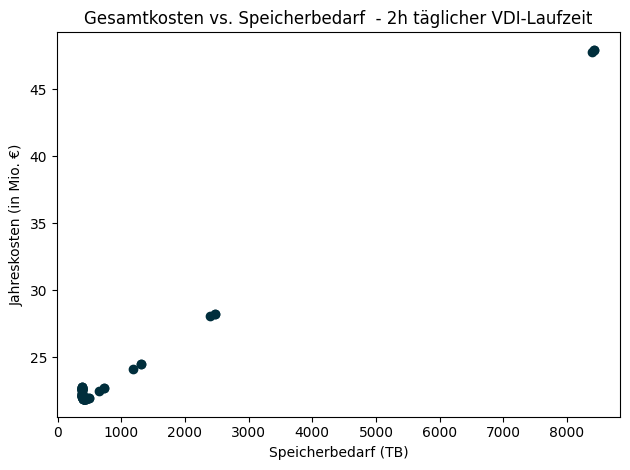

In [96]:
# Titel definieren
title = f"Gesamtkosten vs. Speicherbedarf {modi}"

# Speicherpfad
filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure()
plt.scatter(
    df_results["Speicher (TB)"],
    df_results["Gesamtkosten Jahr"]/1000,
    color="#002E3C"
)
plt.xlabel("Speicherbedarf (TB)")
plt.ylabel("Jahreskosten (in Mio. €)")
plt.title(title)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


Ausgeschlossene Parameter (keine Varianz → keine Korrelation):
- VDI-Fixkosten
- Ø User


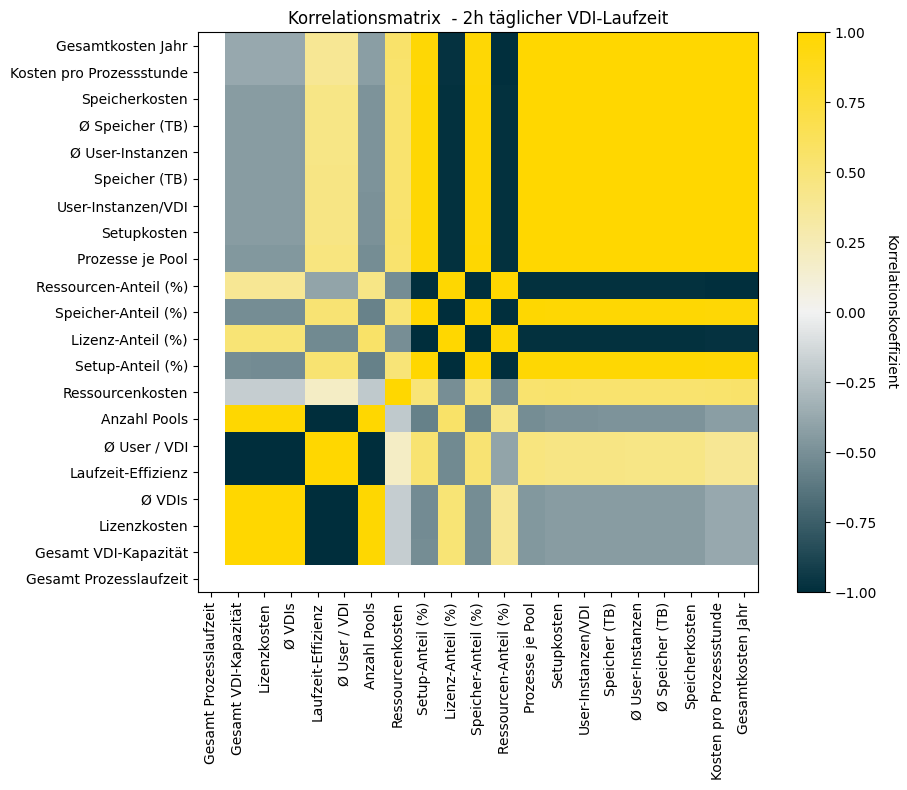

In [97]:
# =========================
# Robuste Korrelationsanalyse (mit Export)
# =========================

# Nur numerische Spalten
numeric_df = df_results.select_dtypes(include="number")

# Varianz prüfen
stds = numeric_df.std()

# Problematische Spalten (Varianz = 0)
problematic_cols = stds[stds == 0].index.tolist()

print("Ausgeschlossene Parameter (keine Varianz → keine Korrelation):")
for col in problematic_cols:
    print(f"- {col}")

# Nur Spalten mit Varianz > 0 behalten
numeric_df_var = numeric_df.loc[:, stds > 0]

# =========================
# Custom Colormap (divergierend)
# =========================
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_corr",
    [
        "#002E3C",  # negativ (− Extrem)
        "#F2F2F2",  # neutral (0)
        "#FFD700"   # positiv (+ Extrem)
    ],
    N=256
)

# =========================
# Korrelationsmatrix
# =========================
corr = numeric_df_var.corr()

# Zielvariable
target = "Gesamtkosten Jahr"

# Sortierung nach absoluter Korrelation zum Ziel
sort_order = (
    corr[target]
    .abs()
    .sort_values(ascending=False)
    .index
)

corr_sorted = corr.loc[sort_order, sort_order]

# =========================
# Plot
# =========================

title = f"Korrelationsmatrix {modi}"

filename = re.sub(r"[^\w\s-]", "", title).strip().replace(" ", "_") + ".png"
filepath = os.path.join(export_path, filename)

plt.figure(figsize=(10, 8))

plt.imshow(
    corr_sorted,
    cmap=custom_cmap,
    vmin=-1,
    vmax=1
)

plt.xticks(
    range(len(corr_sorted.columns)),
    corr_sorted.columns,
    rotation=90
)
plt.yticks(
    range(len(corr_sorted.columns)),
    corr_sorted.columns
)
plt.gca().invert_xaxis()

plt.title(title)

cbar = plt.colorbar()
cbar.set_label(
    "Korrelationskoeffizient",
    rotation=270,
    labelpad=15
)

plt.tight_layout()
plt.savefig(filepath, dpi=300)
plt.show()


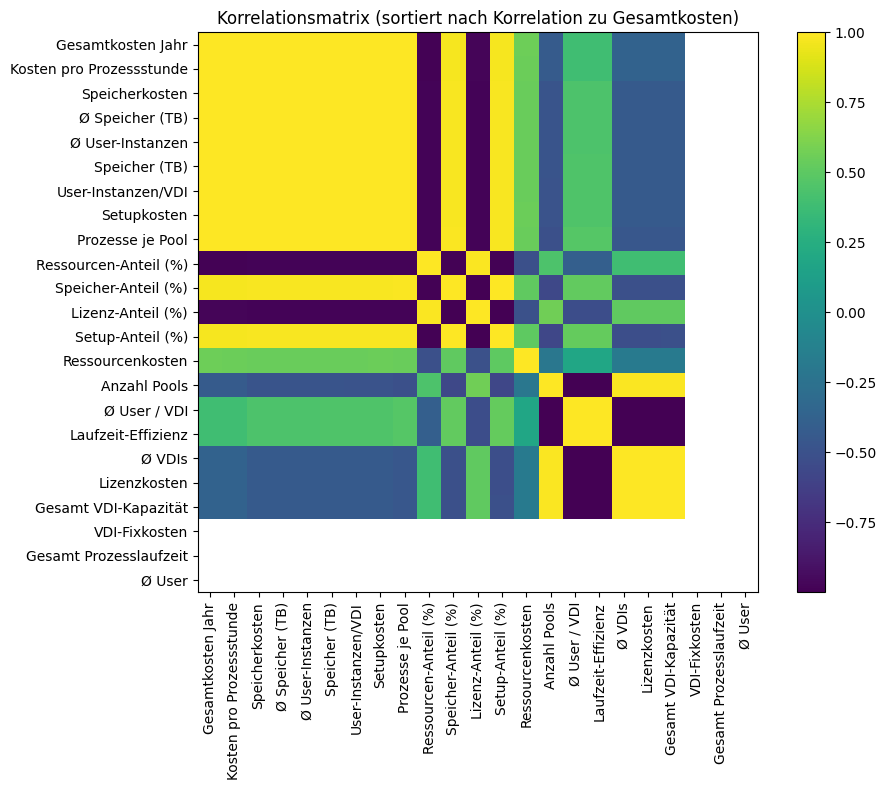

In [98]:
numeric_df = df_results.select_dtypes(include="number")
corr = numeric_df.corr()

target = "Gesamtkosten Jahr"

sort_order = (
    corr[target]
    .abs()
    .sort_values(ascending=False)
    .index
)

corr_sorted = corr.loc[sort_order, sort_order]

plt.figure(figsize=(10, 8))
plt.imshow(corr_sorted)
plt.xticks(range(len(corr_sorted.columns)), corr_sorted.columns, rotation=90)
plt.yticks(range(len(corr_sorted.columns)), corr_sorted.columns)
plt.title("Korrelationsmatrix (sortiert nach Korrelation zu Gesamtkosten)")
plt.colorbar()
plt.tight_layout()
plt.show()


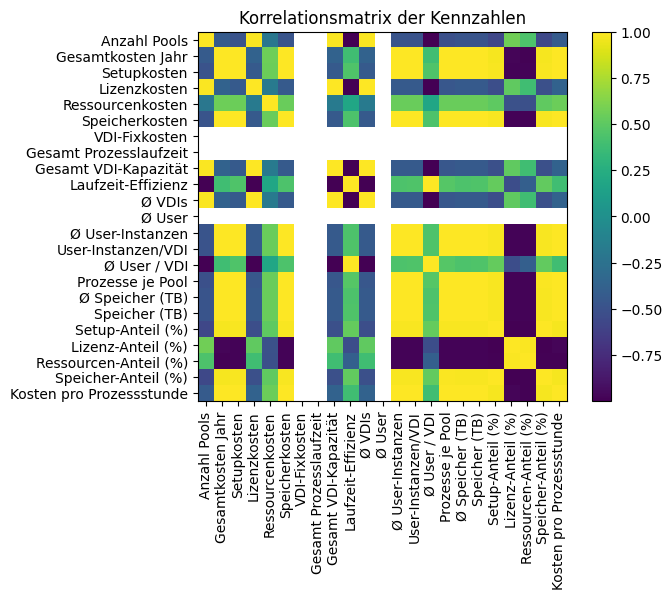

In [99]:
numeric_df = df_results.select_dtypes(include="number")
corr = numeric_df.corr()
corr["Gesamtkosten Jahr"].sort_values(ascending=False)
plt.figure()
plt.imshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Korrelationsmatrix der Kennzahlen")
plt.colorbar()
plt.show()


In [100]:
display(corr.round(2))


,Anzahl Pools,Gesamtkosten Jahr,Setupkosten,Lizenzkosten,Ressourcenkosten,Speicherkosten,VDI-Fixkosten,Gesamt Prozesslaufzeit,Gesamt VDI-Kapazität,Laufzeit-Effizienz,...,User-Instanzen/VDI,Ø User / VDI,Prozesse je Pool,Ø Speicher (TB),Speicher (TB),Setup-Anteil (%),Lizenz-Anteil (%),Ressourcen-Anteil (%),Speicher-Anteil (%),Kosten pro Prozessstunde
Anzahl Pools,1.00,-0.42,-0.49,0.99,-0.20,-0.48,NaN,NaN,0.99,-0.99,...,-0.49,-0.99,-0.51,-0.48,-0.48,-0.57,0.57,0.44,-0.57,-0.42
Gesamtkosten Jahr,-0.42,1.00,1.00,-0.37,0.56,1.00,NaN,NaN,-0.37,0.38,...,1.00,0.38,0.99,1.00,1.00,0.97,-0.97,-0.98,0.97,1.00
Setupkosten,-0.49,1.00,1.00,-0.44,0.55,1.00,NaN,NaN,-0.44,0.45,...,1.00,0.45,1.00,1.00,1.00,0.98,-0.98,-0.98,0.98,1.00
Lizenzkosten,0.99,-0.37,-0.44,1.00,-0.18,-0.43,NaN,NaN,1.00,-1.00,...,-0.44,-1.00,-0.46,-0.43,-0.43,-0.52,0.51,0.38,-0.51,-0.37
Ressourcenkosten,-0.20,0.56,0.55,-0.18,1.00,0.55,NaN,NaN,-0.18,0.19,...,0.55,0.19,0.54,0.55,0.54,0.51,-0.51,-0.52,0.51,0.55
Speicherkosten,-0.48,1.00,1.00,-0.43,0.55,1.00,NaN,NaN,-0.43,0.44,...,1.00,0.44,1.00,1.00,1.00,0.98,-0.98,-0.98,0.98,1.00
VDI-Fixkosten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gesamt Prozesslaufzeit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gesamt VDI-Kapazität,0.99,-0.37,-0.44,1.00,-0.18,-0.43,NaN,NaN,1.00,-1.00,...,-0.44,-1.00,-0.46,-0.43,-0.43,-0.52,0.51,0.38,-0.51,-0.37
Laufzeit-Effizienz,-0.99,0.38,0.45,-1.00,0.19,0.44,NaN,NaN,-1.00,1.00,...,0.45,1.00,0.47,0.44,0.45,0.53,-0.53,-0.40,0.52,0.38


In [101]:
corr["Gesamtkosten Jahr"].sort_values(ascending=False)


Gesamtkosten Jahr           1.000000
Kosten pro Prozessstunde    1.000000
Speicherkosten              0.997726
Ø Speicher (TB)             0.997726
Ø User-Instanzen            0.997663
Speicher (TB)               0.997638
User-Instanzen/VDI          0.997449
Setupkosten                 0.997421
Prozesse je Pool            0.994994
Speicher-Anteil (%)         0.974053
Setup-Anteil (%)            0.972060
Ressourcenkosten            0.556211
Ø User / VDI                0.382893
Laufzeit-Effizienz          0.382852
Gesamt VDI-Kapazität       -0.371313
Lizenzkosten               -0.371364
Ø VDIs                     -0.371364
Anzahl Pools               -0.422768
Lizenz-Anteil (%)          -0.972694
Ressourcen-Anteil (%)      -0.984590
VDI-Fixkosten                    NaN
Gesamt Prozesslaufzeit           NaN
Ø User                           NaN
Name: Gesamtkosten Jahr, dtype: float64